<a href="https://colab.research.google.com/github/u-masao/YutaroOgawa_pytorch_advanced/blob/master/2_objectdetection/2_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

『つくりながら学ぶ! PyTorchによる発展ディープラーニング』 のサンプルコードを Google Colaboratory で動作にしました。

オリジナルリポジトリ

https://github.com/YutaroOgawa/pytorch_advanced

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! git clone https://github.com/YutaroOgawa/pytorch_advanced.git
! ln -s pytorch_advanced/2_objectdetection/data data
! ln -s pytorch_advanced/2_objectdetection/utils utils


fatal: destination path 'pytorch_advanced' already exists and is not an empty directory.


In [3]:

import os
import urllib.request
import zipfile
import tarfile

In [4]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [5]:

# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./drive/MyDrive/weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [6]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [7]:
# 学習済みのSSD用のVGGのパラメータをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [8]:
# 学習済みのSSD300モデルをフォルダ「weights」にダウンロード
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch

url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

SSDなど物体検出アルゴリズム用のDatasetとDataLoaderを作成します。

VOC2012データセットを対象とします。


# 2.2 Datasetの実装

1.	物体検出で使用するDatasetクラスを作成できるようになる
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する



# 2.3 DataLoaderの実装

1.	物体検出で使用するDataLoaderクラスを作成できるようになる



In [9]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [10]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

画像データ、アノテーションデータへのファイルパスのリストを作成する

In [11]:
# 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する


def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)  # リストに追加
        train_anno_list.append(anno_path)  # リストに追加

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)  # リストに追加
        val_anno_list.append(anno_path)  # リストに追加

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [12]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 動作確認
print(train_img_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


xml形式のアノテーションデータをリストに変換する

In [13]:
# 「XML形式のアノテーション」を、リスト形式に変換するクラス


class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [14]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [15]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)


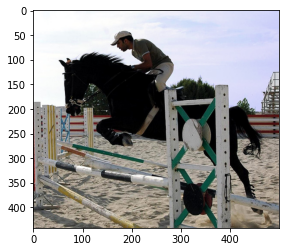

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


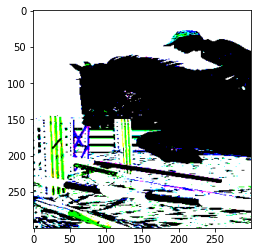

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


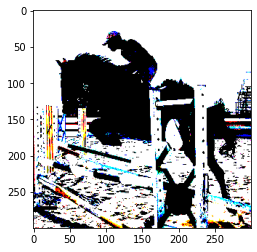

In [16]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


Datasetを作成する

In [17]:
# VOC2012のDatasetを作成する


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [18]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

DataLoaderを作成する

In [19]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets


In [20]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [21]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823


以上

SSDのネットワークモデルと順伝搬forward関数を作成します。

# 2.4 ネットワークモデルの実装
SSDのネットワークモデルを構築している4つのモジュールを把握する
SSDのネットワークモデルを作成できるようになる
SSDで使用する様々な大きさのデフォルトボックスの実装方法を理解する

# 2.5 順伝搬関数の実装
Non-Maximum Suppressionを理解する
SSDの推論時に使用するDetectクラスの順伝搬を理解する
SSDの順伝搬を実装できるようになる



In [22]:
# パッケージのimport
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

vggモジュールを実装

In [23]:
# 35層にわたる、vggモジュールを作成
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 動作確認
vgg_test = make_vgg()
print(vgg_test)


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

extrasモジュールを実装

In [24]:
# 8層にわたる、extrasモジュールを作成
def make_extras():
    layers = []
    in_channels = 1024  # vggモジュールから出力された、extraに入力される画像チャネル数

    # extraモジュールの畳み込み層のチャネル数を設定するコンフィギュレーション
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 活性化関数のReLUは今回はSSDモデルの順伝搬のなかで用意することにし、
    # extraモジュールでは用意していません

    return nn.ModuleList(layers)


# 動作確認
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


locモジュールとconfモジュールを実装

In [25]:
# デフォルトボックスのオフセットを出力するloc_layers、
# デフォルトボックスに対する各クラスの信頼度confidenceを出力するconf_layersを作成


def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)


# 動作確認
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


L2Norm層を実装

In [26]:
# convC4_3からの出力をscale=20のL2Normで正規化する層
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 親クラスのコンストラクタ実行
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 係数weightの初期値として設定する値
        self.reset_parameters()  # パラメータの初期化
        self.eps = 1e-10

    def reset_parameters(self):
        '''結合パラメータを大きさscaleの値にする初期化を実行'''
        init.constant_(self.weight, self.scale)  # weightの値がすべてscale（=20）になる

    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''

        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])になります
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形します
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

デフォルトボックスを実装

In [27]:
# デフォルトボックスを出力するクラス
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 初期設定
        self.image_size = cfg['input_size']  # 画像サイズの300
        # [38, 19, …] 各sourceの特徴量マップのサイズ
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # sourceの個数=6
        self.steps = cfg['steps']  # [8, 16, …] DBoxのピクセルサイズ
        
        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 小さい正方形のDBoxのピクセルサイズ（正確には面積）
        
        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 大きい正方形のDBoxのピクセルサイズ（正確には面積）
        
        self.aspect_ratios = cfg['aspect_ratios']  # 長方形のDBoxのアスペクト比

    def make_dbox_list(self):
        '''DBoxを作成する'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # fまでの数で2ペアの組み合わせを作る　f_P_2 個
                # 特徴量の画像サイズ
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBoxの中心座標 x,y　ただし、0～1で規格化している
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # アスペクト比1の小さいDBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # アスペクト比1の大きいDBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # その他のアスペクト比のdefBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxが画像の外にはみ出るのを防ぐため、大きさを最小0、最大1にする
        output.clamp_(max=1, min=0)

        return output

In [28]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


SSDクラスを実装

In [29]:
# SSDクラスを作成する
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()


# 動作確認
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

2.5 順伝搬の実装

関数decodeを実装する

In [30]:
# オフセット情報を使い、DBoxをBBoxに変換する関数


def decode(loc, dbox_list):
    """
    オフセット情報を使い、DBoxをBBoxに変換する。

    Parameters
    ----------
    loc:  [8732,4]
        SSDモデルで推論するオフセット情報。
    dbox_list: [8732,4]
        DBoxの情報

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBoxの情報
    """

    # DBoxは[cx, cy, width, height]で格納されている
    # locも[Δcx, Δcy, Δwidth, Δheight]で格納されている

    # オフセット情報からBBoxを求める
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])となります

    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2  # 座標(xmin,ymin)へ変換
    boxes[:, 2:] += boxes[:, :2]  # 座標(xmax,ymax)へ変換

    return boxes

Non-Maximum Suppressionを行う関数を実装する

In [31]:
# Non-Maximum Suppressionを行う関数


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。

    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報

    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアの和（OR）の面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去

    # whileのループが抜けたら終了

    return keep, count

Detectクラスを実装する

In [32]:
# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する


class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # confをソフトマックス関数で正規化するために用意
        self.conf_thresh = conf_thresh  # confがconf_thresh=0.01より高いDBoxのみを扱う
        self.top_k = top_k  # nm_supressionでconfの高いtop_k個を計算に使用する, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressionでIOUがnms_thresh=0.45より大きいと、同一物体へのBBoxとみなす

    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """

        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)

        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confのコピーを作成
            conf_scores = conf_preds[i].clone()

            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):

                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]

                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue

                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす

                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数

                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

SSDクラスを実装する

In [33]:
# SSDクラスを作成する


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数=21

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928])
        # confのサイズはtorch.Size([batch_num, 183372])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル


SSDネットワークモデルの損失関数を作成します。

# 2.6 損失関数の実装
jaccard係数を用いたmatch関数の動作を理解する
Hard Negative Miningを理解する
2種類の損失関数（SmoothL1Loss関数、交差エントロピー誤差関数）の働きを理解する



In [34]:
# パッケージのimport
import torch
import torch.nn as nn
import torch.nn.functional as F

# フォルダ「utils」にある関数matchを記述したmatch.pyからimport
from utils.match import match

損失関数クラスMultiBoxLossを実装する

In [35]:
class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードが特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

# 2.7 学習と検証の実施

本ファイルでは、SSDの学習と検証の実施を行います。手元のマシンで動作を確認後、AWSのGPUマシンで計算します。
p2.xlargeで約6時間かかります。

学習目標
SSDの学習を実装できるようになる
事前準備
フォルダ「utils」のssd_model.pyをします


In [36]:
# パッケージのimport
import os.path as osp
import random
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

In [37]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)


使用デバイス： cuda:0


DatasetとDataLoaderを作成する

In [39]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn


# ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# DataLoaderを作成する
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

ネットワークモデルの作成する

In [40]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load(weights_dir + '/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


損失関数と最適化手法を定義する

In [41]:
from utils.ssd_model import MultiBoxLoss

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

学習・検証を実施する

In [42]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv(weights_dir+"/log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), weights_dir+'/ssd300_' +
                       str(epoch+1) + '.pth')

In [43]:
# 学習・検証を実行する
num_epochs= 10  
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/10
-------------
（train）
イテレーション 10 || Loss: 17.1412 || 10iter: 25.2211 sec.
イテレーション 20 || Loss: 14.0396 || 10iter: 17.2720 sec.
イテレーション 30 || Loss: 11.6867 || 10iter: 17.1613 sec.
イテレーション 40 || Loss: 11.1687 || 10iter: 17.2331 sec.
イテレーション 50 || Loss: 9.3383 || 10iter: 17.0683 sec.
イテレーション 60 || Loss: 9.4820 || 10iter: 17.0729 sec.
イテレーション 70 || Loss: 9.2233 || 10iter: 16.7548 sec.
イテレーション 80 || Loss: 9.0431 || 10iter: 17.2410 sec.
イテレーション 90 || Loss: 8.3560 || 10iter: 17.4134 sec.
イテレーション 100 || Loss: 7.6681 || 10iter: 17.3139 sec.
イテレーション 110 || Loss: 7.8279 || 10iter: 17.3875 sec.
イテレーション 120 || Loss: 7.4158 || 10iter: 17.1162 sec.
イテレーション 130 || Loss: 8.0278 || 10iter: 17.3863 sec.
イテレーション 140 || Loss: 8.1951 || 10iter: 17.6041 sec.
イテレーション 150 || Loss: 7.5275 || 10iter: 17.0834 sec.
イテレーション 160 || Loss: 7.8151 || 10iter: 17.5678 sec.
イテレーション 170 || Loss: 7.6436 || 10iter: 17.2719 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:1769.0856 ||Epoch

# 2.8 推論の実施
本ファイルでは、学習させたSSDで物体検出を行います。

学習目標
SSDの推論を実装できるようになる

事前準備
学習させた重みパラメータを用意
フォルダ「utils」のssd_predict_show.pyを使用します


In [44]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

推論を実行する

In [46]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load(weights_dir+'/ssd300_10.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load(weights_dir+'/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


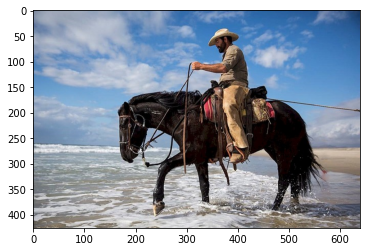

RuntimeError: ignored

In [47]:
from utils.ssd_model import DataTransform

# 1. 画像読み込み
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # アノテーションはないので、""にする
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSDで予測
net.eval()  # ネットワークを推論モードへ
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、クラス、confのtop200、規格化されたBBoxの情報）
#   規格化されたBBoxの情報（確信度、xmin, ymin, xmax, ymax）


In [ ]:
# 画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

# ファイルパス
image_file_path = "./data/cowboy-757575_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)


# 2.8 推論の実施の付録。学習と検証のDataLoaderに実施する
学習させたSSDで物体検出を行います。

VOC2012の訓練データセットと検証データセットに対して、学習済みSSDの推論を実施し、推論結果と正しい答えであるアノテーションデータの両方を表示させるファイルです。

学習させたSSDモデルが正しいアノテーションデータとどれくらい近いのかなどを確認したいケースでは、こちらもご使用ください。

事前準備
フォルダ「utils」に2.3～2.7までで実装した内容をまとめたssd_model.pyがあることを確認してください
学習させた重みパラメータを用意

In [ ]:
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline


推論用の関数とクラスを作成する


In [ ]:
def ssd_predict(img_index, img_list, dataset, net=None, dataconfidence_level=0.5):
    """
    SSDで予測させる関数。

    Parameters
    ----------
    img_index:  int
        データセット内の予測対象画像のインデックス。
    img_list: list
        画像のファイルパスのリスト
    dataset: PyTorchのDataset
        画像のDataset
    net: PyTorchのNetwork
        学習させたSSDネットワーク
    dataconfidence_level: float
        予測で発見とする確信度の閾値

    Returns
    -------
    rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores
    """

    # rgbの画像データを取得
    image_file_path = img_list[img_index]
    img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 正解のBBoxを取得
    im, gt = dataset.__getitem__(img_index)
    true_bbox = gt[:, 0:4] * [width, height, width, height]
    true_label_index = gt[:, 4].astype(int)

    # SSDで予測
    net.eval()  # ネットワークを推論モードへ
    x = im.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 300, 300])
    detections = net(x)
    # detectionsの形は、torch.Size([1, 21, 200, 5])  ※200はtop_kの値

    # confidence_levelが基準以上を取り出す
    predict_bbox = []
    pre_dict_label_index = []
    scores = []
    detections = detections.cpu().detach().numpy()

    # 条件以上の値を抽出
    find_index = np.where(detections[:, 0:, :, 0] >= dataconfidence_level)
    detections = detections[find_index]
    for i in range(len(find_index[1])):  # 抽出した物体数分ループを回す
        if (find_index[1][i]) > 0:  # 背景クラスでないもの
            sc = detections[i][0]  # 確信度
            bbox = detections[i][1:] * [width, height, width, height]
            lable_ind = find_index[1][i]-1  # find_indexはミニバッチ数、クラス、topのtuple
            # （注釈）
            # 背景クラスが0なので1を引く

            # 返り値のリストに追加
            predict_bbox.append(bbox)
            pre_dict_label_index.append(lable_ind)
            scores.append(sc)

    return rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores


In [ ]:
def vis_bbox(rgb_img, bbox, label_index, scores, label_names):
    """
    物体検出の予測結果を画像で表示させる関数。

    Parameters
    ----------
    rgb_img:rgbの画像
        対象の画像データ
    bbox: list
        物体のBBoxのリスト
    label_index: list
        物体のラベルへのインデックス
    scores: list
        物体の確信度。
    label_names: list
        ラベル名の配列

    Returns
    -------
    なし。rgb_imgに物体検出結果が加わった画像が表示される。
    """

    # 枠の色の設定
    num_classes = len(label_names)  # クラス数（背景のぞく）
    colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()

    # 画像の表示
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    currentAxis = plt.gca()

    # BBox分のループ
    for i, bb in enumerate(bbox):

        # ラベル名
        label_name = label_names[label_index[i]]
        color = colors[label_index[i]]  # クラスごとに別の色の枠を与える

        # 枠につけるラベル　例：person;0.72　
        if scores is not None:
            sc = scores[i]
            display_txt = '%s: %.2f' % (label_name, sc)
        else:
            display_txt = '%s: ans' % (label_name)

        # 枠の座標
        xy = (bb[0], bb[1])
        width = bb[2] - bb[0]
        height = bb[3] - bb[1]

        # 長方形を描画する
        currentAxis.add_patch(plt.Rectangle(
            xy, width, height, fill=False, edgecolor=color, linewidth=2))

        # 長方形の枠の左上にラベルを描画する
        currentAxis.text(xy[0], xy[1], display_txt, bbox={
                         'facecolor': color, 'alpha': 0.5})


In [ ]:
class SSDPredictShow():
    """SSDでの予測と画像の表示をまとめて行うクラス"""

    def __init__(self, img_list, dataset,  eval_categories, net=None, dataconfidence_level=0.6):
        self.img_list = img_list
        self.dataset = dataset
        self.net = net
        self.dataconfidence_level = dataconfidence_level
        self.eval_categories = eval_categories

    def show(self, img_index, predict_or_ans):
        """
        物体検出の予測と表示をする関数。

        Parameters
        ----------
        img_index:  int
            データセット内の予測対象画像のインデックス。
        predict_or_ans: text
            'precit'もしくは'ans'でBBoxの予測と正解のどちらを表示させるか指定する

        Returns
        -------
        なし。rgb_imgに物体検出結果が加わった画像が表示される。
        """
        rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores = ssd_predict(img_index, self.img_list,
                                                                 self.dataset,
                                                                 self.net,
                                                                 self.dataconfidence_level)

        if predict_or_ans == "predict":
            vis_bbox(rgb_img, bbox=predict_bbox, label_index=pre_dict_label_index,
                     scores=scores, label_names=self.eval_categories)

        elif predict_or_ans == "ans":
            vis_bbox(rgb_img, bbox=true_bbox, label_index=true_label_index,
                     scores=None, label_names=self.eval_categories)


推論を実行する


In [ ]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn


# ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# Datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


In [ ]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)
net.eval()

# SSDの学習済みの重みを設定
net_weights = torch.load(weights_dir+'/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

#net_weights = torch.load(weights_dir+'/ssd300_mAP_77.43_v2.pth',
#                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


In [ ]:
# 結果の描画
ssd = SSDPredictShow(img_list=train_img_list, dataset=train_dataset, eval_categories=voc_classes,
                     net=net, dataconfidence_level=0.6)
img_index = 0
ssd.show(img_index, "predict")
ssd.show(img_index, "ans")


In [ ]:
# 結果の描画
ssd = SSDPredictShow(img_list=val_img_list, dataset=val_dataset, eval_categories=voc_classes,
                     net=net, dataconfidence_level=0.6)
img_index = 0
ssd.show(img_index, "predict")
ssd.show(img_index, "ans")
